# Notebook 07 – Summary of All Experiments

This notebook summarizes the experimental results across the project notebooks:
- 02: Baseline price-only MLP
- 03: Price-only MLP (window/hidden sweeps)
- 04: Price + 4h intraday MLP
- 05: Price-only GRU
- 06: Price + 4h intraday GRU
- 08: Price + macro features (MLP/GRU/LSTM)
- 09b: Price + news experiments
- 10: Price-only regression (reported as directional accuracy)

We report test accuracy (and best validation accuracy where available) and compare against a majority-class baseline for each dataset variant.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ROOT = Path("..").resolve()
DATA_PROC = ROOT / "data" / "processed"
NOTEBOOKS_DIR = ROOT / "notebooks"

print(ROOT)
print("data/processed:", DATA_PROC)
print("notebooks:", NOTEBOOKS_DIR)

C:\Users\KDP only\Documents\ANN_Final_Project\spy-ann
data/processed: C:\Users\KDP only\Documents\ANN_Final_Project\spy-ann\data\processed
notebooks: C:\Users\KDP only\Documents\ANN_Final_Project\spy-ann\notebooks


In [2]:
# Load datasets used across experiments and compute majority-class baselines

def _load_parquet_if_exists(path: Path) -> pd.DataFrame | None:
    if path.exists():
        df = pd.read_parquet(path)
        if "date" in df.columns:
            df["date"] = pd.to_datetime(df["date"])
        return df
    return None

df_daily = _load_parquet_if_exists(DATA_PROC / "daily_merged.parquet")
df_intraday = _load_parquet_if_exists(DATA_PROC / "daily_with_4h.parquet")
df_macro = _load_parquet_if_exists(DATA_PROC / "daily_with_macro.parquet")

# News features are stored separately; merge them onto daily_merged when present
df_news = None
news_path = DATA_PROC / "news_daily_features.parquet"
if df_daily is not None and news_path.exists():
    df_news_feats = pd.read_parquet(news_path)
    df_news_feats["date"] = pd.to_datetime(df_news_feats["date"])
    df_news = df_daily.merge(df_news_feats, on="date", how="inner")

def _majority_baseline(df: pd.DataFrame | None) -> float:
    if df is None or "label_up" not in df.columns:
        return float("nan")
    vc = df["label_up"].value_counts(normalize=True)
    return float(vc.max()) if len(vc) else float("nan")

BASELINES = {
    "daily_full": _majority_baseline(df_daily),
    "daily+4h_short": _majority_baseline(df_intraday),
    "daily+macro": _majority_baseline(df_macro),
    "daily+news": _majority_baseline(df_news),
}

print("=== DATASETS FOUND ===")
print("daily_merged:", None if df_daily is None else df_daily.shape)
print("daily_with_4h:", None if df_intraday is None else df_intraday.shape)
print("daily_with_macro:", None if df_macro is None else df_macro.shape)
print("daily+news (merged):", None if df_news is None else df_news.shape)

print("\n=== MAJORITY BASELINES ===")
for k, v in BASELINES.items():
    print(f"{k:>14}: {v}")

=== DATASETS FOUND ===
daily_merged: (3753, 15)
daily_with_4h: (260, 24)
daily_with_macro: (3753, 21)
daily+news (merged): (3303, 20)

=== MAJORITY BASELINES ===
    daily_full: 0.5526245670130562
daily+4h_short: 0.5923076923076923
   daily+macro: 0.5526245670130562
    daily+news: 0.5488949439903118


In [3]:
import ast
import json
import re
from typing import Any, Iterable

def _read_notebook(path: Path) -> dict[str, Any]:
    return json.loads(path.read_text(encoding="utf-8"))

def _iter_notebook_text(nb: dict[str, Any]) -> Iterable[str]:
    for cell in nb.get("cells", []):
        src = cell.get("source", [])
        if isinstance(src, list):
            yield "".join(src)
        elif isinstance(src, str):
            yield src

        for out in cell.get("outputs", []) or []:
            if out.get("output_type") == "stream":
                txt = out.get("text", "")
                if isinstance(txt, list):
                    yield "".join(txt)
                else:
                    yield str(txt)
                continue

            data = out.get("data", {}) or {}
            txt_plain = data.get("text/plain")
            if txt_plain is not None:
                if isinstance(txt_plain, list):
                    yield "".join(txt_plain)
                else:
                    yield str(txt_plain)

def _parse_w_hidden_block(
    text: str,
    *,
    model_family: str,
    variant: str,
    features: str,
    dataset: str,
    source_notebook: str,
) -> list[dict[str, Any]]:
    out: list[dict[str, Any]] = []
    pat = re.compile(
        r"W=(?P<w>\d+),\s*"
        r"(?P<hdesc>hidden=.*?|hidden=\(.*?\))\s*\|\s*"
        r"best_val_acc=(?P<val>[0-9.]+),\s*test_acc=(?P<test>[0-9.]+)"
    )
    for m in pat.finditer(text):
        out.append({
            "model_family": model_family,
            "variant": variant,
            "features": features,
            "window_size": int(m.group("w")),
            "hidden_desc": m.group("hdesc"),
            "dataset": dataset,
            "best_val_acc": float(m.group("val")),
            "test_acc": float(m.group("test")),
            "metric": "accuracy",
            "source_notebook": source_notebook,
        })
    return out

def _parse_notebook_02(path: Path) -> list[dict[str, Any]]:
    nb = _read_notebook(path)
    text = "\n".join(_iter_notebook_text(nb))

    # window_size is set in the source
    w = None
    for s in _iter_notebook_text(nb):
        m = re.search(r"^window_size\s*=\s*(\d+)\s*$", s, flags=re.MULTILINE)
        if m:
            w = int(m.group(1))
            break

    test_m = re.search(r"Test Accuracy:\s*([0-9.]+)", text)
    test_acc = float(test_m.group(1)) if test_m else float("nan")

    # best validation accuracy: max over epoch log lines
    val_accs = [float(v) for v in re.findall(r"val_loss=[0-9.]+\s+acc=([0-9.]+)", text)]
    best_val_acc = max(val_accs) if val_accs else float("nan")

    return [{
        "model_family": "MLP",
        "variant": "Price-only",
        "features": "Daily only",
        "window_size": int(w) if w is not None else 0,
        "hidden_desc": "as in 02_baseline_price_only",
        "dataset": "daily_full",
        "best_val_acc": float(best_val_acc),
        "test_acc": float(test_acc),
        "metric": "accuracy",
        "source_notebook": path.name,
    }]

def _parse_notebook_08_macro(path: Path) -> list[dict[str, Any]]:
    nb = _read_notebook(path)
    out: list[dict[str, Any]] = []
    for chunk in _iter_notebook_text(nb):
        for line in chunk.splitlines():
            line = line.strip()
            if not (line.startswith("{'model':") and line.endswith("}")):
                continue
            try:
                d = ast.literal_eval(line)
            except Exception:
                continue
            if not isinstance(d, dict):
                continue
            if "test_acc" not in d or "best_val_acc" not in d:
                continue
            model = str(d.get("model", ""))
            out.append({
                "model_family": model,
                "variant": "Price+macro",
                "features": "Daily + macro",
                "window_size": int(d.get("window_size", 0) or 0),
                "hidden_desc": f"{d.get('hidden_desc','')} | scaled={d.get('scaled', None)}".strip(" |"),
                "dataset": "daily+macro",
                "best_val_acc": float(d.get("best_val_acc")),
                "test_acc": float(d.get("test_acc")),
                "metric": "accuracy",
                "source_notebook": path.name,
            })
    return out

def _parse_notebook_09b_news(path: Path) -> list[dict[str, Any]]:
    nb = _read_notebook(path)
    text = "\n".join(_iter_notebook_text(nb))
    out: list[dict[str, Any]] = []

    # Table: model features window_size val_acc test_acc
    table_pat = re.compile(
        r"^\s*model\s+features\s+window_size\s+val_acc\s+test_acc\s*$"
        r"(?P<body>(?:\n.*)+?)"
        r"(?=\n\s*$|\n\S)",
        flags=re.MULTILINE,
    )

    for tm in table_pat.finditer(text):
        body = tm.group("body")
        for line in body.splitlines():
            m = re.match(r"^\s*(MLP|GRU|LSTM)\s+(\S+)\s+(\d+)\s+([0-9.]+)\s+([0-9.]+)\s*$", line)
            if not m:
                continue
            model, feats, w, val, test = m.group(1), m.group(2), int(m.group(3)), float(m.group(4)), float(m.group(5))
            feats_norm = feats.replace("_", "-")
            if "news" in feats_norm:
                features = "Daily + news"
                dataset = "daily+news"
                variant = "Price+news"
            else:
                features = "Daily only"
                dataset = "daily_full"
                variant = "Price-only"
            out.append({
                "model_family": model,
                "variant": variant,
                "features": features,
                "window_size": w,
                "hidden_desc": "as in 09b_price_plus_news_experiments",
                "dataset": dataset,
                "best_val_acc": val,
                "test_acc": test,
                "metric": "accuracy",
                "source_notebook": path.name,
            })

    # Table: config val_acc test_acc (regularization sweeps)
    reg_pat = re.compile(
        r"^\s*config\s+val_acc\s+test_acc\s*$"
        r"(?P<body>(?:\n.*)+?)"
        r"(?=\n\s*$|\n\S)",
        flags=re.MULTILINE,
    )
    for rm in reg_pat.finditer(text):
        body = rm.group("body")
        for line in body.splitlines():
            m = re.match(r"^\s*\d+\s+(.+?)\s+([0-9.]+)\s+([0-9.]+)\s*$", line)
            if not m:
                continue
            config = m.group(1).strip()
            val = float(m.group(2))
            test = float(m.group(3))
            model = "GRU" if "GRU" in config else "Unknown"
            if "news" in config.lower():
                features = "Daily + news"
                dataset = "daily+news"
            else:
                features = "Daily only"
                dataset = "daily_full"
            out.append({
                "model_family": model,
                "variant": config,
                "features": features,
                "window_size": float("nan"),
                "hidden_desc": "regularization sweep",
                "dataset": dataset,
                "best_val_acc": val,
                "test_acc": test,
                "metric": "accuracy",
                "source_notebook": path.name,
            })

    # Deduplicate rows that can show up multiple times depending on outputs
    if out:
        df = pd.DataFrame(out).drop_duplicates()
        out = df.to_dict("records")
    return out

def _parse_notebook_10_regression(path: Path) -> list[dict[str, Any]]:
    nb = _read_notebook(path)
    text = "\n".join(_iter_notebook_text(nb))
    accs = [float(x) for x in re.findall(r"Directional accuracy \(sign\(pred\) vs sign\(true\)\):\s*([0-9.]+)", text)]
    if not accs:
        return []
    # If multiple runs were printed, keep them all (they may correspond to different configs).
    out: list[dict[str, Any]] = []
    for i, a in enumerate(accs, start=1):
        out.append({
            "model_family": "Regression",
            "variant": f"Price-only regression run {i}",
            "features": "Daily only",
            "window_size": float("nan"),
            "hidden_desc": "directional accuracy from regression",
            "dataset": "daily_full",
            "best_val_acc": float("nan"),
            "test_acc": a,
            "metric": "directional_accuracy",
            "source_notebook": path.name,
        })
    return out

def collect_all_results() -> pd.DataFrame:
    results: list[dict[str, Any]] = []

    # 02 baseline
    p02 = NOTEBOOKS_DIR / "02_baseline_price_only.ipynb"
    if p02.exists():
        results.extend(_parse_notebook_02(p02))

    # 03 price-only MLP sweeps
    p03 = NOTEBOOKS_DIR / "03_price_only_experiments.ipynb"
    if p03.exists():
        nb = _read_notebook(p03)
        text = "\n".join(_iter_notebook_text(nb))
        results.extend(_parse_w_hidden_block(
            text,
            model_family="MLP",
            variant="Price-only",
            features="Daily only",
            dataset="daily_full",
            source_notebook=p03.name,
        ))

    # 04 price+4h MLP sweeps
    p04 = NOTEBOOKS_DIR / "04_price_plus_4h_experiments.ipynb"
    if p04.exists():
        nb = _read_notebook(p04)
        text = "\n".join(_iter_notebook_text(nb))
        results.extend(_parse_w_hidden_block(
            text,
            model_family="MLP",
            variant="Price+4h",
            features="Daily + 4h intraday",
            dataset="daily+4h_short",
            source_notebook=p04.name,
        ))

    # 05 price-only GRU sweeps
    p05 = NOTEBOOKS_DIR / "05_price_only_gru_experiments.ipynb"
    if p05.exists():
        nb = _read_notebook(p05)
        text = "\n".join(_iter_notebook_text(nb))
        results.extend(_parse_w_hidden_block(
            text,
            model_family="GRU",
            variant="Price-only",
            features="Daily only",
            dataset="daily_full",
            source_notebook=p05.name,
        ))

    # 06 price+4h GRU sweeps
    p06 = NOTEBOOKS_DIR / "06_price_plus_4h_gru_experiments.ipynb"
    if p06.exists():
        nb = _read_notebook(p06)
        text = "\n".join(_iter_notebook_text(nb))
        results.extend(_parse_w_hidden_block(
            text,
            model_family="GRU",
            variant="Price+4h",
            features="Daily + 4h intraday",
            dataset="daily+4h_short",
            source_notebook=p06.name,
        ))

    # 08 macro experiments
    p08 = NOTEBOOKS_DIR / "08_price_plus_macro_experiments.ipynb"
    if p08.exists():
        results.extend(_parse_notebook_08_macro(p08))

    # 09b news experiments
    p09b = NOTEBOOKS_DIR / "09b_price_plus_news_experiments.ipynb"
    if p09b.exists():
        results.extend(_parse_notebook_09b_news(p09b))

    # 10 regression
    p10 = NOTEBOOKS_DIR / "10_price_only_regression.ipynb"
    if p10.exists():
        results.extend(_parse_notebook_10_regression(p10))

    df = pd.DataFrame(results)
    if df.empty:
        return df

    # Normalize types
    for col in ["best_val_acc", "test_acc"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    if "window_size" in df.columns:
        df["window_size"] = pd.to_numeric(df["window_size"], errors="coerce")

    return df

results_df = collect_all_results()
results_df.sort_values(["metric", "test_acc"], ascending=[True, False])

,model_family,variant,features,window_size,hidden_desc,dataset,best_val_acc,test_acc,metric,source_notebook
18,GRU,Price+4h,Daily + 4h intraday,20.0,hidden=32,daily+4h_short,0.473700,0.578900,accuracy,06_price_plus_4h_gru_experiments.ipynb
19,GRU,Price+4h,Daily + 4h intraday,20.0,hidden=64,daily+4h_short,0.473700,0.578900,accuracy,06_price_plus_4h_gru_experiments.ipynb
17,GRU,Price-only,Daily only,60.0,hidden=32,daily_full,0.582500,0.556400,accuracy,05_price_only_gru_experiments.ipynb
20,GRU,Price+4h,Daily + 4h intraday,30.0,hidden=32,daily+4h_short,0.555600,0.555600,accuracy,06_price_plus_4h_gru_experiments.ipynb
21,GRU,Price+4h,Daily + 4h intraday,30.0,hidden=64,daily+4h_short,0.555600,0.555600,accuracy,06_price_plus_4h_gru_experiments.ipynb
15,GRU,Price-only,Daily only,30.0,hidden=32,daily_full,0.584600,0.547100,accuracy,05_price_only_gru_experiments.ipynb
4,MLP,Price-only,Daily only,30.0,"hidden=(32, 16)",daily_full,0.574200,0.546300,accuracy,03_price_only_experiments.ipynb
12,MLP,Price+4h,Daily + 4h intraday,30.0,"hidden=(32, 16)",daily+4h_short,0.396600,0.545500,accuracy,04_price_plus_4h_experiments.ipynb
13,MLP,Price+4h,Daily + 4h intraday,30.0,"hidden=(64, 32)",daily+4h_short,0.396600,0.545500,accuracy,04_price_plus_4h_experiments.ipynb
14,MLP,Price+4h,Daily + 4h intraday,30.0,"hidden=(128, 64)",daily+4h_short,0.396600,0.545500,accuracy,04_price_plus_4h_experiments.ipynb


In [4]:
def baseline_for_row(row):
    return BASELINES.get(row.get("dataset"), float("nan"))

results_df["baseline_acc"] = results_df.apply(baseline_for_row, axis=1)

# For non-accuracy metrics, keep the baseline columns but they may be less meaningful.
results_df["test_minus_baseline"] = results_df["test_acc"] - results_df["baseline_acc"]

results_df_sorted = results_df.sort_values(by="test_acc", ascending=False)
results_df_sorted

,model_family,variant,features,window_size,hidden_desc,dataset,best_val_acc,test_acc,metric,source_notebook,baseline_acc,test_minus_baseline
19,GRU,Price+4h,Daily + 4h intraday,20.0,hidden=64,daily+4h_short,0.473700,0.578900,accuracy,06_price_plus_4h_gru_experiments.ipynb,0.592308,-0.013408
18,GRU,Price+4h,Daily + 4h intraday,20.0,hidden=32,daily+4h_short,0.473700,0.578900,accuracy,06_price_plus_4h_gru_experiments.ipynb,0.592308,-0.013408
17,GRU,Price-only,Daily only,60.0,hidden=32,daily_full,0.582500,0.556400,accuracy,05_price_only_gru_experiments.ipynb,0.552625,0.003775
20,GRU,Price+4h,Daily + 4h intraday,30.0,hidden=32,daily+4h_short,0.555600,0.555600,accuracy,06_price_plus_4h_gru_experiments.ipynb,0.592308,-0.036708
21,GRU,Price+4h,Daily + 4h intraday,30.0,hidden=64,daily+4h_short,0.555600,0.555600,accuracy,06_price_plus_4h_gru_experiments.ipynb,0.592308,-0.036708
49,Regression,Price-only regression run 1,Daily only,NaN,directional accuracy from regression,daily_full,NaN,0.552600,directional_accuracy,10_price_only_regression.ipynb,0.552625,-0.000025
15,GRU,Price-only,Daily only,30.0,hidden=32,daily_full,0.584600,0.547100,accuracy,05_price_only_gru_experiments.ipynb,0.552625,-0.005525
4,MLP,Price-only,Daily only,30.0,"hidden=(32, 16)",daily_full,0.574200,0.546300,accuracy,03_price_only_experiments.ipynb,0.552625,-0.006325
12,MLP,Price+4h,Daily + 4h intraday,30.0,"hidden=(32, 16)",daily+4h_short,0.396600,0.545500,accuracy,04_price_plus_4h_experiments.ipynb,0.592308,-0.046808
14,MLP,Price+4h,Daily + 4h intraday,30.0,"hidden=(128, 64)",daily+4h_short,0.396600,0.545500,accuracy,04_price_plus_4h_experiments.ipynb,0.592308,-0.046808


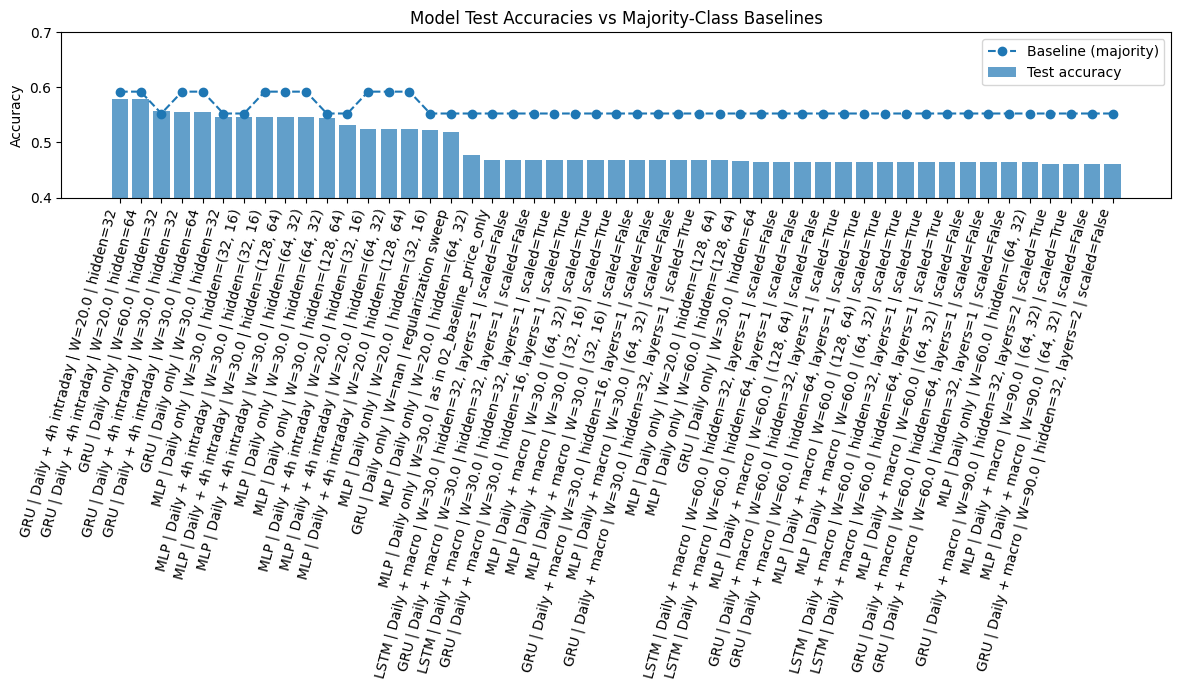

In [5]:
# Plot accuracy-type results against their dataset majority baseline
df_plot = results_df[results_df["metric"] == "accuracy"].copy()
df_plot = df_plot.sort_values(by="test_acc", ascending=False)

plt.figure(figsize=(12, 7))

labels = []
test_accs = []
baselines = []

for _, row in df_plot.iterrows():
    label = f"{row['model_family']} | {row['features']} | W={row['window_size']} | {row['hidden_desc']}"
    labels.append(label)
    test_accs.append(row["test_acc"])
    baselines.append(row["baseline_acc"])

x = np.arange(len(labels))

plt.bar(x, test_accs, alpha=0.7, label="Test accuracy")
plt.plot(x, baselines, marker="o", linestyle="--", label="Baseline (majority)")

plt.xticks(x, labels, rotation=75, ha="right")
plt.ylabel("Accuracy")
plt.title("Model Test Accuracies vs Majority-Class Baselines")
plt.ylim(0.4, 0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
summary_by_family = (
    results_df
    .groupby(["metric", "model_family", "features"], dropna=False)["test_minus_baseline"]
    .agg(["mean", "max", "min", "count"])
    .reset_index()
    .sort_values(["metric", "mean"], ascending=[True, False])
 )
summary_by_family

,metric,model_family,features,mean,max,min,count
0,accuracy,GRU,Daily + 4h intraday,-0.025058,-0.013408,-0.036708,4
2,accuracy,GRU,Daily only,-0.030478,0.003775,-0.087225,4
6,accuracy,MLP,Daily only,-0.053747,-0.006325,-0.088025,9
4,accuracy,MLP,Daily + 4h intraday,-0.057658,-0.046808,-0.068508,6
3,accuracy,LSTM,Daily + macro,-0.086365,-0.084481,-0.087307,6
1,accuracy,GRU,Daily + macro,-0.087095,-0.084481,-0.091899,10
5,accuracy,MLP,Daily + macro,-0.087095,-0.084481,-0.091899,10
7,directional_accuracy,Regression,Daily only,-0.000025,-0.000025,-0.000025,1
